# VAE

In [1]:
USE_SERVER = True
if USE_SERVER:
    !pip install elasticsearch
    !pip install elasticsearch_dsl
    !pip install pymed
    !pip install gensim
    !pip install torchsummary

  Using cached elasticsearch-7.8.0-py2.py3-none-any.whl (188 kB)
  Using cached elasticsearch_dsl-7.2.1-py2.py3-none-any.whl (53 kB)
  Using cached pymed-0.8.9-py3-none-any.whl (9.6 kB)
     |████████████████████████████████| 24.2 MB 29.9 MB/s eta 0:00:01
  Using cached smart_open-2.1.0.tar.gz (116 kB)
  Created wheel for smart-open: filename=smart_open-2.1.0-py3-none-any.whl size=110317 sha256=de83e5c41cbe349a05fa85db4cd05793b9eb1c02dc87a18c399f3b5b0096e369
  Stored in directory: /home/ubuntu/.cache/pip/wheels/a4/9b/d5/85705a7ab783cd6f7bd718f01d3b1396272f30044e3c36401a
Successfully built smart-open
  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [97]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import utils
import os
from utils import PROJECT_ROOT, DATA_PATH
import yuval_module.paper_source as PaperSource

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

import py_4.get_mesh_vec as get_mesh_vec
import py_3.sim_matrix_3 as sim_matrix_3
import py_4.get_all_features as get_all_features 

from torch.utils.data import Dataset, DataLoader

from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
mesh_embed=get_mesh_vec.MeshEmbeddings(PROJECT_ROOT + "data/mesh_data/MeSHFeatureGeneratedByDeepWalk.csv")

In [10]:
FILE = "enriched_labeled_dataset_large" 
if os.path.exists(PROJECT_ROOT + DATA_PATH + FILE):
    print("READING FROM LOCAL")
    if FILE.split(".")[1] == "json":
        df = pd.read_json(PROJECT_ROOT + DATA_PATH + FILE)
    else:
        df = pd.read_csv(PROJECT_ROOT + DATA_PATH + FILE)
    #ps = PaperSource()
else:
    print("PULLING FROM S3")
    ps = sim_matrix_3.load_dataset(FILE)
    df = ps.get_dataset()

df.drop(columns=["last_author_country"],inplace=True)
df.rename(columns={'ORG_STATE':'last_author_country'},inplace=True)

print("FILE PULLED")

PULLING FROM S3
FILE PULLED


### Run VAE 

In [11]:
cd ..

/home/ubuntu/AYP


In [12]:
auth_core = pd.read_csv("data/train_set_author_names.csv")["0"]
auth_eps = pd.read_csv("data/val_set_author_names.csv")["0"]
auth_usecase = pd.read_csv("data/test_set_author_names.csv")["0"]

In [181]:
selection_train = list(set(df['last_author_name']) - set(auth_usecase))[:1500]
selection_test = list(set(df['last_author_name']) - set(auth_usecase))[1500:2000]

In [174]:
#settings

BATCH_SIZE= 8
EPOCHS = 30
cuda = torch.cuda.is_available()
seed = 42
log_interval = 5
num_workers = 2

#check for cuda
device = torch.device('cuda' if cuda else 'cpu')

torch.manual_seed(seed)
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

device

device(type='cuda')

In [175]:
class ToyDS(Dataset):
    def __init__(self,df,selection,vae_features = None):
        super().__init__()
        self.df = df[df['last_author_name'].isin(selection)]
        if vae_features is None:
            print("Creating new VAE FEATURES")
            self.vae_features = get_all_features.VAE_Features(self.df)
        else:
            print("Using pre-defined VAE FEATURES")
            self.vae_features = vae_features
        self.features = self.vae_features.get_all_features(self.df)
        print(list(self.vae_features.mesh_features.mesh_missing))
        self.input_dim = self.vae_features.input_dims
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        features = self.features[idx]
        return features
    
    def __getvae__(self):
        return self.vae_features

In [176]:
train_set = ToyDS(df, selection_train)
train_loader=DataLoader(dataset= train_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

Creating new VAE FEATURES
'/home/ubuntu/AYP/code/models/names_epochs_2_vectorSize_64_window_2.model' already exits. Using existing model to re-generate results.
'/home/ubuntu/AYP/code/models/co_authors_epochs_2_vectorSize_64_window_2.model' already exits. Using existing model to re-generate results.


/home/ubuntu/AYP/code/py_4/get_all_features.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co_authors']=df.authors.apply( lambda x: [i['name'] for i in x] )


Defining new scaler
['MESH NAME NOT FOUND: Mitophagy', 'MESH NAME NOT FOUND: Female', "MESH NAME NOT FOUND: Practice Patterns, Physicians'", 'MESH NAME NOT FOUND: Broadly Neutralizing Antibodies', 'MESH NAME NOT FOUND: B-Cell Lymphoma 3 Protein', 'MESH NAME NOT FOUND: Conditioning, Psychological', 'MESH NAME NOT FOUND: Inhibition, Psychological', 'MESH NAME NOT FOUND: Chlorocebus aethiops', 'MESH NAME NOT FOUND: Confounding Factors, Epidemiologic', 'MESH NAME NOT FOUND: Male', 'MESH NAME NOT FOUND: Recognition, Psychology', 'MESH NAME NOT FOUND: Phosphoinositide-3 Kinase Inhibitors', 'MESH NAME NOT FOUND: Infections', 'MESH NAME NOT FOUND: Stimuli Responsive Polymers']


In [166]:
print("The number of features: ",train_set.input_dim)
print("The number of train data: ",train_set.__len__())

The number of features:  64
The number of train data:  2500


In [167]:
class VAE(nn.Module):
    def __init__(self, input_dim = train_set.input_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(self.input_dim, 64)
        self.fc21 = nn.Linear(64, 32)
        self.fc22 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, self.input_dim)
        
        #Want to initialize logvar weights to 0
#         self.fc22.weight.data.fill_(0)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z

In [168]:
def loss_function(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64), reduction='sum')

    MSE = F.mse_loss(recon_x, x.view(-1, train_set.input_dim))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= BATCH_SIZE * train_set.input_dim

    return MSE + KLD

In [169]:
log_interval = 10

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [170]:
from torchsummary import summary
summary(model, (20,train_set.input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           4,160
            Linear-2                   [-1, 32]           2,080
            Linear-3                   [-1, 32]           2,080
            Linear-4                   [-1, 64]           2,112
            Linear-5                   [-1, 64]           4,160
Total params: 14,592
Trainable params: 14,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [171]:
def train_epoch(tr_loader, model, criterion, optimizer, num_epochs):
    model.train()
    train_log = []
    
    for epoch in range(num_epochs):
        print("Started training epoch no. {}".format(epoch+1))
        train_loss= 0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            recon_batch, mu, logvar, z = model(data)
            loss = criterion(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}\n'.format(
            epoch, train_loss / len(train_loader.dataset)))
        train_log.append({
            'epoch': epoch,
            'train_loss': train_loss / len(train_loader)})
    return train_log

In [191]:
def test_model(test_loader, model):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar, _ = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [114]:
train_log = train_epoch(train_loader,model,loss_function,optimizer,num_epochs= EPOCHS)

Started training epoch no. 1
Train Epoch: 0 [0/2500 (0%)]	Loss: 1.469735
Train Epoch: 0 [80/2500 (3%)]	Loss: 1.684468
Train Epoch: 0 [160/2500 (6%)]	Loss: 0.479023
Train Epoch: 0 [240/2500 (10%)]	Loss: 0.482190
Train Epoch: 0 [320/2500 (13%)]	Loss: 0.360738
Train Epoch: 0 [400/2500 (16%)]	Loss: 0.416651
Train Epoch: 0 [480/2500 (19%)]	Loss: 0.429609
Train Epoch: 0 [560/2500 (22%)]	Loss: 0.338763
Train Epoch: 0 [640/2500 (26%)]	Loss: 0.232148
Train Epoch: 0 [720/2500 (29%)]	Loss: 0.465773
Train Epoch: 0 [800/2500 (32%)]	Loss: 0.177119
Train Epoch: 0 [880/2500 (35%)]	Loss: 0.163909
Train Epoch: 0 [960/2500 (38%)]	Loss: 0.568398
Train Epoch: 0 [1040/2500 (42%)]	Loss: 0.300856
Train Epoch: 0 [1120/2500 (45%)]	Loss: 0.354745
Train Epoch: 0 [1200/2500 (48%)]	Loss: 0.227633
Train Epoch: 0 [1280/2500 (51%)]	Loss: 0.386452
Train Epoch: 0 [1360/2500 (54%)]	Loss: 0.123944
Train Epoch: 0 [1440/2500 (58%)]	Loss: 0.342129
Train Epoch: 0 [1520/2500 (61%)]	Loss: 0.287151
Train Epoch: 0 [1600/2500 (64%

In [116]:
train_log

[{'epoch': 0, 'train_loss': 2.678865297819479},
 {'epoch': 1, 'train_loss': 1.1976502431086458},
 {'epoch': 2, 'train_loss': 1.0680429128031381},
 {'epoch': 3, 'train_loss': 1.0341266369857727},
 {'epoch': 4, 'train_loss': 1.0194465192362143},
 {'epoch': 5, 'train_loss': 1.0122760945615676},
 {'epoch': 6, 'train_loss': 1.0070156514073332},
 {'epoch': 7, 'train_loss': 1.0046762004256629},
 {'epoch': 8, 'train_loss': 1.0038238088734233},
 {'epoch': 9, 'train_loss': 1.0040661465055265},
 {'epoch': 10, 'train_loss': 1.0013142653737968},
 {'epoch': 11, 'train_loss': 1.0019235621435574},
 {'epoch': 12, 'train_loss': 1.002016035988689},
 {'epoch': 13, 'train_loss': 1.000093188243933},
 {'epoch': 14, 'train_loss': 1.0001908958719943},
 {'epoch': 15, 'train_loss': 1.0001192818434474},
 {'epoch': 16, 'train_loss': 1.0010630025650367},
 {'epoch': 17, 'train_loss': 1.0001688158740631},
 {'epoch': 18, 'train_loss': 1.000037825621736},
 {'epoch': 19, 'train_loss': 1.0006708033359089},
 {'epoch': 20,

In [189]:
test_set = ToyDS(df, selection_test, vae_features = train_set.__getvae__())
test_loader=DataLoader(dataset= test_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

Using pre-defined VAE FEATURES


/home/ubuntu/AYP/code/py_4/get_all_features.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co_authors']=df.authors.apply( lambda x: [i['name'] for i in x] )


Using old scaler
['MESH NAME NOT FOUND: Mitophagy', 'MESH NAME NOT FOUND: Female', "MESH NAME NOT FOUND: Practice Patterns, Physicians'", 'MESH NAME NOT FOUND: Broadly Neutralizing Antibodies', 'MESH NAME NOT FOUND: B-Cell Lymphoma 3 Protein', 'MESH NAME NOT FOUND: Conditioning, Psychological', 'MESH NAME NOT FOUND: Inhibition, Psychological', 'MESH NAME NOT FOUND: Chlorocebus aethiops', 'MESH NAME NOT FOUND: Confounding Factors, Epidemiologic', 'MESH NAME NOT FOUND: Male', 'MESH NAME NOT FOUND: Recognition, Psychology', 'MESH NAME NOT FOUND: Phosphoinositide-3 Kinase Inhibitors', 'MESH NAME NOT FOUND: Infections', 'MESH NAME NOT FOUND: Stimuli Responsive Polymers', 'MESH NAME NOT FOUND: Copper-Transporting ATPases']


In [ ]:
for data in test_loader:
    print(data)

tensor([[-9.8190e-01, -1.4370e-01, -7.4746e-01,  7.7553e-02, -4.8941e-01,
          5.7530e-02,  3.8934e-01, -3.7781e-01, -4.4986e-01,  1.0980e+00,
         -5.0763e-02,  1.9606e-01, -5.5546e-01, -1.0925e+00,  2.9295e-01,
          4.0396e-01, -9.1165e-01,  4.0175e-01,  5.1580e-01,  1.2969e-01,
          6.6094e-01, -1.1563e-01,  5.9494e-01, -2.5166e-01, -7.8161e-01,
          3.3268e-01, -3.0861e-01, -4.6124e-01, -2.7474e-02, -3.4499e-01,
         -6.1243e-01, -1.0484e+00,  3.5489e-01,  4.6461e-01,  5.7272e-02,
         -6.7570e-01, -7.0845e-01,  3.5920e-01, -8.5851e-01, -4.8731e-01,
         -1.1980e-01,  8.8258e-01,  5.1856e-01,  4.3946e-01,  1.1368e+00,
          6.1532e-01,  3.4989e-01, -4.1586e-01,  3.8995e-01,  4.1233e-02,
          1.0127e+00,  3.7860e-01,  9.1602e-02,  2.4763e-01,  7.3918e-01,
         -7.1378e-01,  2.7603e-01,  9.8274e-02, -3.1790e-02,  7.3010e-01,
          4.3017e-01, -8.2597e-01, -3.2067e-02,  3.9823e-01],
        [-1.1725e+00, -2.3730e-01, -1.1052e+00, -2

In [192]:
test_model(test_loader, model)

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'mat1' in call to _th_addmm

# Test

In [153]:
selection = [auth_usecase[109]]
print(df[df['last_author_name'].isin(selection)]["PI_IDS"].value_counts())

7127687     10
10594466     8
11990780     1
Name: PI_IDS, dtype: int64


In [154]:
train_vae = train_set.__getvae__()
test_set = ToyDS(df, selection,train_vae)
test_loader=DataLoader(dataset= test_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

Using pre-defined VAE FEATURES
Using old scaler
['MESH NAME NOT FOUND: Female', "MESH NAME NOT FOUND: Practice Patterns, Physicians'", 'MESH NAME NOT FOUND: Phosphoinositide-3 Kinase Inhibitors', 'MESH NAME NOT FOUND: Chlorocebus aethiops', 'MESH NAME NOT FOUND: Male', 'MESH NAME NOT FOUND: Phospholipid Hydroperoxide Glutathione Peroxidase', 'MESH NAME NOT FOUND: Outcome Assessment, Health Care', 'MESH NAME NOT FOUND: Diet, Healthy', 'MESH NAME NOT FOUND: Copper-Transporting ATPases']


/home/ubuntu/AYP/code/py_4/get_all_features.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co_authors']=df.authors.apply( lambda x: [i['name'] for i in x] )


In [155]:
bottle_neck=[]
recon_batchs = []
for batch_idx, data in enumerate(test_loader):
            data = data.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            recon_batch, mu, logvar, _= model(data)
            if cuda:
                bottle_neck.extend(mu.cpu().detach().numpy())
                recon_batchs.extend(recon_batch.cpu().detach().numpy())
            else:
                bottle_neck.extend(mu.detach().numpy())
                recon_batchs.extend(recon_batch.detach().numpy())
bottle_neck = np.array(bottle_neck)
recon_batchs = np.array(recon_batchs)
print(bottle_neck.shape)
print(recon_batchs.shape)

(19, 32)
(19, 64)


In [157]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=1, n_iter=1000,random_state=42)
tsne_results = tsne.fit_transform(bottle_neck)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 0.634541
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.133377
[t-SNE] KL divergence after 1000 iterations: 0.337330
t-SNE done! Time elapsed: 0.14081168174743652 seconds


In [158]:
df_subset=pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['PI'] = list(df[df['last_author_name'].isin(selection)]["PI_IDS"])

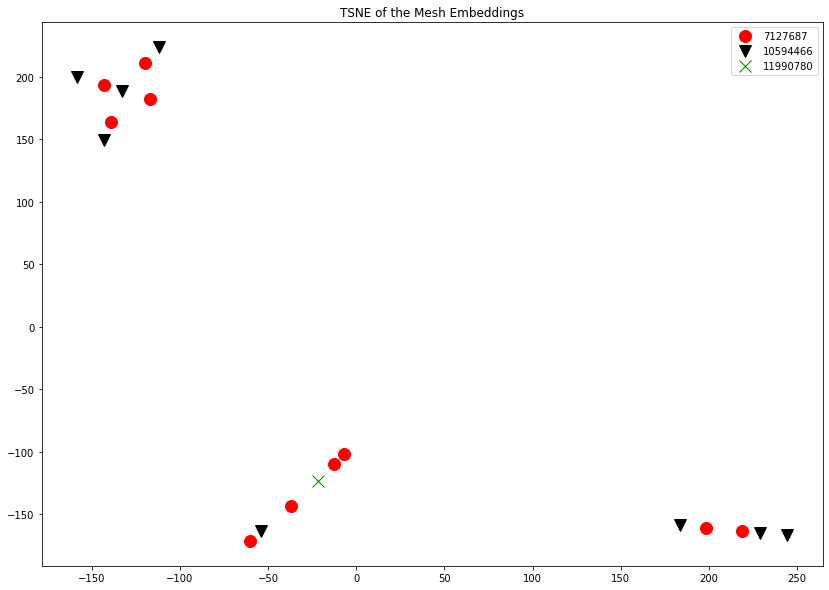

In [159]:
groups = df_subset.groupby('PI')
markers = ['o','v',"x"]
colors = ["red","black","green"]
# Plot
fig, ax = plt.subplots(figsize=(14,10))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i, (name, group) in enumerate(groups):
    ax.set_title("TSNE of the Mesh Embeddings")
    ax.plot(group['tsne-2d-one'], group['tsne-2d-two'], marker=markers[i], linestyle='', ms=12, label=name, color=colors[i])
ax.legend()
plt.show()
fig.tight_layout();

# fig.savefig('code/img/TSNE_Plots/mesh.png', bbox_inches='tight')

### SANITY TESTS

#### ON INPUT DIM:

In [160]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=1000, random_state=42)
tsne_inputs = tsne.fit_transform(test_set.features)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
input_testset=pd.DataFrame()
input_testset['tsne-2d-one'] = tsne_inputs[:,0]
input_testset['tsne-2d-two'] = tsne_inputs[:,1]
input_testset['PI'] = list(df[df['last_author_name'].isin(selection)]["PI_IDS"])

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.712021
[t-SNE] KL divergence after 1000 iterations: 0.240680
t-SNE done! Time elapsed: 0.14115023612976074 seconds


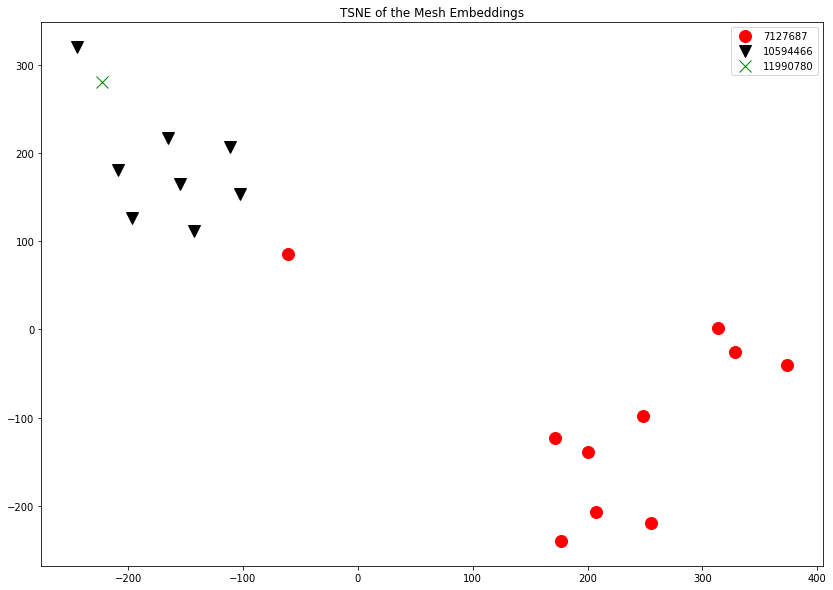

In [161]:
groups = input_testset.groupby('PI')
markers = ['o','v',"x"]
colors = ["red","black","green"]
# Plot
fig, ax = plt.subplots(figsize=(14,10))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i, (name, group) in enumerate(groups):
    ax.set_title("TSNE of the Mesh Embeddings")
    ax.plot(group['tsne-2d-one'], group['tsne-2d-two'], marker=markers[i], linestyle='', ms=12, label=name, color=colors[i])
ax.legend()
plt.show()
fig.tight_layout();

# fig.savefig('code/img/TSNE_Plots/mesh.png', bbox_inches='tight')

### OUTPUT DIMS

In [162]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=1000,random_state=42)
tsne_output = tsne.fit_transform(recon_batchs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
output_testset=pd.DataFrame()
output_testset['tsne-2d-one'] = tsne_output[:,0]
output_testset['tsne-2d-two'] = tsne_output[:,1]
output_testset['PI'] = list(df[df['last_author_name'].isin(selection)]["PI_IDS"])

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 0.000622
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.051392
[t-SNE] KL divergence after 1000 iterations: 0.264274
t-SNE done! Time elapsed: 0.14203095436096191 seconds


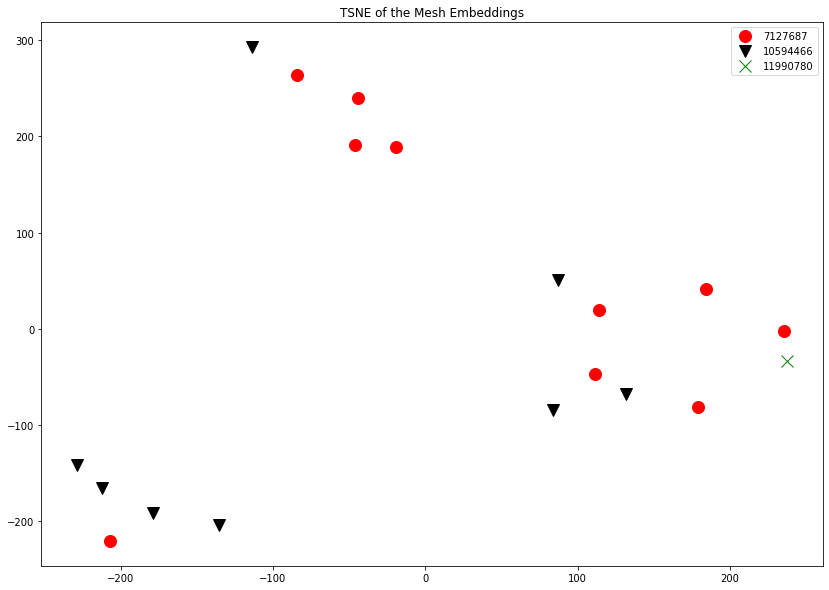

In [163]:
groups = output_testset.groupby('PI')
markers = ['o','v',"x"]
colors = ["red","black","green"]
# Plot
fig, ax = plt.subplots(figsize=(14,10))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i, (name, group) in enumerate(groups):
    ax.set_title("TSNE of the Mesh Embeddings")
    ax.plot(group['tsne-2d-one'], group['tsne-2d-two'], marker=markers[i], linestyle='', ms=12, label=name, color=colors[i])
ax.legend()
plt.show()
fig.tight_layout();

# fig.savefig('code/img/TSNE_Plots/mesh.png', bbox_inches='tight')